# Desafio Final: Reclamações do Consumidor

O seguinte notebook tem como objetivo a análise exploratória e modelagem de dados com base em dados históricos de reclamações de consumidores do Procon. Como membros da equipe de dados do Procon, recebemos diariamente uma grande quantidade de dados de reclamações dos consumidores e cada reclamação tem um tempo definido para ser resolvida entre o cliente e a empresa em questão. Para ajudar a nossa equipe a entender melhor esses dados, recebemos uma amostra histórica de reclamações de 2012 a 2016, extraídos do [Kaggle](https://www.kaggle.com/datasets/gerosa/procon). Com base nesses dados, nossa equipe está encarregada de responder a algumas perguntas importantes sobre o tempo médio de resolução de reclamações, empresas mais reclamadas e produtos mais problemáticos. Neste notebook, realizaremos uma análise exploratória de dados e modelagem para responder a essas perguntas.

1. Análise de dados:
    1. Existe alguma sazonalidade na data de abertura de uma reclamação? Ou seja, mais consumidores abrem reclamações em determinada época do ano?
    2. Qual o tempo médio de uma reclamação ativa (da abertura até a data de fechamento)?
    3. O número de reclamações varia de acordo com a região? E de acordo com o estado? E se ponderarmos pela população média do estado?
    4. Quais as empresas que receberam mais reclamações dos consumidores? E por região?E por estado?
2. Modelagem: Prevendo o tempo de uma reclamação ativa
    1. Quais as variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa?
    2. Construa variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa a partir dos dados. Exemplo. crie variáveis dummy referentes ao período do ano, região, etc.
    3. Análise a correlação entre as variáveis.
    4. Construa um modelo de regreção linear em que queremos estimar o tempo de uma reclamação ativa.


# Entendendo os dados

Importação das Bibliotecas

In [ ]:
!pip install pyspellchecker
!pip install unidecode
!pip install plotly

# Bibliotecas padrão do Python
import pickle
import string
from datetime import timedelta

# Bibliotecas de processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker
import unidecode

#Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Bibliotecas para processamento de dados
import numpy as np
import pandas as pd
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split

# Bibliotecas para modelos de machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Configuração de exibição de tabelas do pandas
pd.set_option('display.max_columns', None)

Importação dos dados

In [ ]:
dtype = {'CEPConsumidor': str}
df_2012 = pd.read_csv(r"dados\reclamacoes-fundamentadas-sindec-2012.csv")
df_2013 = pd.read_csv(r"dados\reclamacoes-fundamentadas-sindec-2013.csv", dtype=dtype)
df_2014 = pd.read_csv(r"dados\reclamacoes-fundamentadas-sindec-2014.csv", dtype=dtype)
df_2015 = pd.read_csv(r"dados\reclamacoes-fundamentadas-sindec-2015.csv", dtype=dtype)
df_2016 = pd.read_csv(r"dados\reclamacoes-fundamentadas-sindec-2016.csv")
df_populacao = pd.read_csv(r"dados\ibge_populacao.csv")
# Estimativa populacional para 2016
# Fonte: IBGE. Diretoria de Pesquisas - DPE -  Coordenação de População e Indicadores Socias - COPIS.

Visualizando e organizando DataFrame Reclamações

In [ ]:
dfs = [df_2012, df_2013, df_2014, df_2015, df_2016]

if all([list(df.columns) == list(dfs[0].columns) for df in dfs]):
    print('Todos os dataframes têm as mesmas colunas')
else:
    print('Pelo menos um dos dataframes tem colunas diferentes')

Todos os dataframes têm as mesmas colunas


In [ ]:
# juntando arquivos em 1 dataframe único

df = pd.DataFrame(columns=df_2012.columns)

for df_ano in dfs:
    df = pd.concat([df, df_ano])

Formatando DataFrame População

In [ ]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Regiao     27 non-null     object
 1   UF         27 non-null     object
 2   Populacao  27 non-null     object
dtypes: object(3)
memory usage: 776.0+ bytes


In [ ]:
df_populacao['Populacao'] = df_populacao['Populacao'].str.replace('.', '', regex=False).astype(int)

In [ ]:
# visualizar dataframe sem colunas escondidas
pd.set_option('display.max_columns', None)
df.head(5)

,AnoCalendario,DataArquivamento,DataAbertura,CodigoRegiao,Regiao,UF,strRazaoSocial,strNomeFantasia,Tipo,NumeroCNPJ,RadicalCNPJ,RazaoSocialRFB,NomeFantasiaRFB,CNAEPrincipal,DescCNAEPrincipal,Atendida,CodigoAssunto,DescricaoAssunto,CodigoProblema,DescricaoProblema,SexoConsumidor,FaixaEtariaConsumidor,CEPConsumidor
0,2012,2012-07-13 17:44:45.000,2009-09-17 10:48:42.000,3,Sudeste,ES,IBI PROMOTORA DE VENDAS LTDA.,IBI CARD,1,7.448120e+13,74481201.0,IBI PROMOTORA DE VENDAS LTDA.,NaN,7490104.0,ATIVIDADES DE INTERMEDIAÇÃO E AGENCIAMENTO DE ...,N,54,Cartão de Crédito,32,Calculo de prestação em atraso,F,mais de 70 anos,29072040
1,2012,2012-07-13 17:37:19.000,2009-09-17 10:02:24.000,3,Sudeste,ES,SAMSUNG ELETRONICA DA AMAZONIA LTDA,SAMSUNG,1,2.802730e+11,280273.0,SAMSUNG ELETRONICA DA AMAZONIA LTDA,SAMSUNG DA AMAZONIA,2640000.0,"FABRICAÇÃO DE APARELHOS DE RECEPÇÃO, REPRODUÇÃ...",N,101,"Telefone ( Convencional, Celular, Interfone, E...",102,"Garantia (Abrangência, cobertura, etc.)",M,entre 31 a 40 anos,29115360
2,2012,2012-07-16 09:07:13.000,2009-09-17 11:36:47.000,3,Sudeste,ES,LINNU''S AUTOMOVEIS LTDA.,LINNUS AUTOMOVEIS,1,3.635548e+13,36355477.0,LINNU'S AUTOMOVEIS LTDA.,NaN,4512902.0,COMÉRCIO SOB CONSIGNAÇÃO DE VEÍCULOS AUTOMOTORES,N,129,Carro Nacional Zero ( Montadora ),111,Venda enganosa,M,entre 21 a 30 anos,29060110
3,2012,2012-12-10 09:05:09.000,2009-09-21 09:01:49.000,5,Centro-oeste,GO,AMAZON PC INDUSTRIA E COMERCIO DE MICROCOMPUTA...,AMAZON PC,1,1.614079e+12,1614079.0,AMAZON PC INDUSTRIA E COMERCIO DE MICROCOMPUTA...,AMAZON PC,2621300.0,FABRICAÇÃO DE EQUIPAMENTOS DE INFORMÁTICA,S,102,Microcomputador / Produtos de Informática,102,"Garantia (Abrangência, cobertura, etc.)",M,entre 21 a 30 anos,75911000
4,2012,2012-07-13 17:51:01.000,2009-09-18 17:32:22.000,3,Sudeste,ES,OFFICINA REVESTIMENTOS LTDA ME,NaN,1,5.444155e+12,5444155.0,OFFICINA REVESTIMENTOS LTDA ME,OFFICINA REVESTIMENTOS,4744005.0,COMÉRCIO VAREJISTA DE MATERIAIS DE CONSTRUÇÃO ...,N,118,Material de Acabamento de Construção Pronto (P...,116,"Contrato/pedido/orçamento (rescisão, descumpri...",M,Nao Informada,29090120


In [ ]:
# Verificando dtypes e dados nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206072 entries, 0 to 203485
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   AnoCalendario          1206072 non-null  object 
 1   DataArquivamento       1206072 non-null  object 
 2   DataAbertura           1206072 non-null  object 
 3   CodigoRegiao           1206072 non-null  object 
 4   Regiao                 1206072 non-null  object 
 5   UF                     1206072 non-null  object 
 6   strRazaoSocial         1206064 non-null  object 
 7   strNomeFantasia        1006636 non-null  object 
 8   Tipo                   1206072 non-null  object 
 9   NumeroCNPJ             1153518 non-null  float64
 10  RadicalCNPJ            1152390 non-null  float64
 11  RazaoSocialRFB         1137442 non-null  object 
 12  NomeFantasiaRFB        547639 non-null   object 
 13  CNAEPrincipal          1133380 non-null  float64
 14  DescCNAEPrincipal  

Aqui foi observado que tem muitas colunas com informações repetidas, colunas com espaços em branco, coluna de data como string.

Em seguida, serão feitas operações de limpeza e organização dos dados.

In [ ]:
columns_meaning = {
    'AnoCalendario': 'Ano de referências',
    'DataArquivamento': 'Encerramento da reclamação',
    'DataAbertura': 'Abertura da reclamação',
    'CodigoRegiao': '1 - North, 2 - Northeast, 3 - Southeast, 4 - South, 5 - Central-West',
    'Regiao': 'Nome da região',
    'UF': 'Sigla do estado',
    'strRazaoSocial': 'Razão social',
    'strNomeFantasia': 'Nome fantasia',
    'Tipo': '1 - Business, 0 - Person',
    'NumeroCNPJ': 'CNPJ',
    'RadicalCNPJ': '',
    'RazaoSocialRFB': '',
    'NomeFantasiaRFB': '',
    'CNAEPrincipal': '',
    'DescCNAEPrincipal': '',
    'Atendida': '',
    'CodigoAssunto': '',
    'DescricaoAssunto': '',
    'CodigoProblema': '',
    'DescricaoProblema': '',
    'SexoConsumidor': '',
    'FaixaEtariaConsumidor': '',
    'CEPConsumidor': '',
}

In [ ]:
df.columns

Index(['AnoCalendario', 'DataArquivamento', 'DataAbertura', 'CodigoRegiao',
       'Regiao', 'UF', 'strRazaoSocial', 'strNomeFantasia', 'Tipo',
       'NumeroCNPJ', 'RadicalCNPJ', 'RazaoSocialRFB', 'NomeFantasiaRFB',
       'CNAEPrincipal', 'DescCNAEPrincipal', 'Atendida', 'CodigoAssunto',
       'DescricaoAssunto', 'CodigoProblema', 'DescricaoProblema',
       'SexoConsumidor', 'FaixaEtariaConsumidor', 'CEPConsumidor'],
      dtype='object')

In [ ]:
# percentual de valores ausentes por coluna
df.isna().mean()*100

AnoCalendario             0.000000
DataArquivamento          0.000000
DataAbertura              0.000000
CodigoRegiao              0.000000
Regiao                    0.000000
UF                        0.000000
strRazaoSocial            0.000663
strNomeFantasia          16.535995
Tipo                      0.000000
NumeroCNPJ                4.357451
RadicalCNPJ               4.450978
RazaoSocialRFB            5.690373
NomeFantasiaRFB          54.593175
CNAEPrincipal             6.027169
DescCNAEPrincipal         6.949088
Atendida                  0.000000
CodigoAssunto             0.000000
DescricaoAssunto          0.000000
CodigoProblema            0.001658
DescricaoProblema         0.001658
SexoConsumidor            0.080509
FaixaEtariaConsumidor     0.000000
CEPConsumidor             6.865759
dtype: float64

In [ ]:
# exclusão de linhas duplicadas

print(f"Tamanho antes da exclusão de registros duplicados: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Tamanho após da exclusão de registros duplicados: {df.shape[0]}")

Tamanho antes da exclusão de registros duplicados: 1206072
Tamanho após da exclusão de registros duplicados: 1205991


In [ ]:
# substituir os valores que estão vazios na coluna strNomeFantasia e strRazaoSocial pelos valores da coluna NomeFantasiaRFB e RazaoSocialRFB
df['strNomeFantasia'].fillna(df['NomeFantasiaRFB'], inplace=True)
df['strRazaoSocial'].fillna(df['RazaoSocialRFB'], inplace=True)
# substituir nomes abreviados
df['SexoConsumidor'].replace(['M'], 'Masculino', inplace=True)
df['SexoConsumidor'].replace(['F'], 'Feminino', inplace=True)
df['Atendida'].replace(['N'], 'Não', inplace=True)
df['Atendida'].replace(['S'], 'Sim', inplace=True)

In [ ]:
# percentual de valores ausentes por coluna
df.isna().mean()*100

AnoCalendario             0.000000
DataArquivamento          0.000000
DataAbertura              0.000000
CodigoRegiao              0.000000
Regiao                    0.000000
UF                        0.000000
strRazaoSocial            0.000663
strNomeFantasia          13.041308
Tipo                      0.000000
NumeroCNPJ                4.353018
RadicalCNPJ               4.446551
RazaoSocialRFB            5.686029
NomeFantasiaRFB          54.592033
CNAEPrincipal             6.022848
DescCNAEPrincipal         6.944828
Atendida                  0.000000
CodigoAssunto             0.000000
DescricaoAssunto          0.000000
CodigoProblema            0.001658
DescricaoProblema         0.001658
SexoConsumidor            0.079934
FaixaEtariaConsumidor     0.000000
CEPConsumidor             6.864977
dtype: float64

Vamos excluir colunas redundantes e desnecessárias. 

- Os números e radicais dos CNJPs não serão importantes para nossas análises finais.
- CódigoRegião e Região têm o mesmo número de ocorrências e trazem a mesma informação. Sendo assim, CódigoRegião será descartada.
- RazaoSocialRFB, NomeFantasiaRFB e strNomeFantasia trazem as mesmas informações que strRazaoSocial, com mais dados nulos, logo não são viáveis manter.
- O CEP traz informações mais detalhadas, mas pode acabar tornando o processamento muito custoso.
- Os pares de variáveis que possuem 'CNAEPrincipal'/'DescCNAEPrincipal' e 'CodigoProblema'/'DescriçãoProblema' também são redundantes, logo manteremos apenas DescCNAEPrincipal e DescriçãoProblema.


Algumas linhas com dados nulos de algumas colunas **não** serão excluídas nesse momento de análise exploratória, para não impactar no quantitativo final.

Com isso, campos vazios colunas de Sexo, Descrição do Problema serão substituídos por 'Não informado'.

In [ ]:
# substituir os valores que estão vazios nas colunas por Não informado
df['SexoConsumidor'].fillna('Não informado', inplace=True)
df['DescricaoProblema'].fillna('Não informado', inplace=True)

In [ ]:
# remover colunas desnecessárias
df.drop(columns=['CodigoRegiao', 'NumeroCNPJ', 'strNomeFantasia', 'RadicalCNPJ', 'RazaoSocialRFB', 'NomeFantasiaRFB', 'CNAEPrincipal', 'CodigoAssunto', 'CodigoProblema', 'CEPConsumidor'], inplace = True)
# verificando DataFrame modificado
df.info(3)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205991 entries, 0 to 203485
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   AnoCalendario          1205991 non-null  object
 1   DataArquivamento       1205991 non-null  object
 2   DataAbertura           1205991 non-null  object
 3   Regiao                 1205991 non-null  object
 4   UF                     1205991 non-null  object
 5   strRazaoSocial         1205983 non-null  object
 6   Tipo                   1205991 non-null  object
 7   DescCNAEPrincipal      1122237 non-null  object
 8   Atendida               1205991 non-null  object
 9   DescricaoAssunto       1205991 non-null  object
 10  DescricaoProblema      1205991 non-null  object
 11  SexoConsumidor         1205991 non-null  object
 12  FaixaEtariaConsumidor  1205991 non-null  object
dtypes: object(13)
memory usage: 128.8+ MB


Vamos tratar os valores nulos restantes.

In [ ]:
round(100 * df.isna().sum()/df.shape[0], 2)

AnoCalendario            0.00
DataArquivamento         0.00
DataAbertura             0.00
Regiao                   0.00
UF                       0.00
strRazaoSocial           0.00
Tipo                     0.00
DescCNAEPrincipal        6.94
Atendida                 0.00
DescricaoAssunto         0.00
DescricaoProblema        0.00
SexoConsumidor           0.00
FaixaEtariaConsumidor    0.00
dtype: float64

In [ ]:
# Removendo linhas vazias da coluna DescCNAEPrincipal
df.dropna(subset=['DescCNAEPrincipal'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122237 entries, 0 to 203484
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   AnoCalendario          1122237 non-null  object
 1   DataArquivamento       1122237 non-null  object
 2   DataAbertura           1122237 non-null  object
 3   Regiao                 1122237 non-null  object
 4   UF                     1122237 non-null  object
 5   strRazaoSocial         1122237 non-null  object
 6   Tipo                   1122237 non-null  object
 7   DescCNAEPrincipal      1122237 non-null  object
 8   Atendida               1122237 non-null  object
 9   DescricaoAssunto       1122237 non-null  object
 10  DescricaoProblema      1122237 non-null  object
 11  SexoConsumidor         1122237 non-null  object
 12  FaixaEtariaConsumidor  1122237 non-null  object
dtypes: object(13)
memory usage: 119.9+ MB


In [ ]:
print(f'Considerando que descartando os registros sem DescCNAEPrincipal, o dataframe ainda teria {df.shape[0]} dados, vamos descartar essas linhas.')

Considerando que descartando os registros sem DescCNAEPrincipal, o dataframe ainda teria 1122237 dados, vamos descartar essas linhas.


In [ ]:
# converter os dtypes das colunas
df['AnoCalendario'] = df['AnoCalendario'].astype(int)
df['DataAbertura'] = pd.to_datetime(df['DataAbertura'])
df['DataArquivamento'] = pd.to_datetime(df['DataArquivamento'])

Foi observado que seria necessário normalizar os dados, pois algumas colunas haviam registros com diferentes pontuações, e isso estava causando divergências nos resultados.

In [ ]:
nltk.download('omw-1.4')

# Baixar as stopwords e o lematizador
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Instanciar o lematizador
lemmatizer = WordNetLemmatizer()

# Criar a lista de stopwords em português
stop_words = set(stopwords.words('portuguese'))
stop_words.add('sa')
stop_words.add('ltda')

import unidecode
# Função para normalizar um texto
def normalize_text(text):
    # Converter para minúsculas
    text = unidecode.unidecode(text.lower())
    
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenizar o texto em palavras
    words = word_tokenize(text)
    
    # Remover as stopwords
    words = [word for word in words if word not in stop_words]
    
    # Lematizar as palavras
    words = [lemmatizer.lemmatize(word) for word in words]
    
    ## Juntar as palavras em um texto novamente
    text = ' '.join(words)
    
    return text

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lnune\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lnune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lnune\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lnune\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df['strRazaoSocial'] = df['strRazaoSocial'].apply(normalize_text)
df['DescCNAEPrincipal'] = df['DescCNAEPrincipal'].apply(normalize_text)
df['DescricaoAssunto'] = df['DescricaoAssunto'].apply(normalize_text)
df['DescricaoProblema'] = df['DescricaoProblema'].apply(normalize_text)
df['strRazaoSocial'].nunique()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122237 entries, 0 to 203484
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AnoCalendario          1122237 non-null  int32         
 1   DataArquivamento       1122237 non-null  datetime64[ns]
 2   DataAbertura           1122237 non-null  datetime64[ns]
 3   Regiao                 1122237 non-null  object        
 4   UF                     1122237 non-null  object        
 5   strRazaoSocial         1122237 non-null  object        
 6   Tipo                   1122237 non-null  object        
 7   DescCNAEPrincipal      1122237 non-null  object        
 8   Atendida               1122237 non-null  object        
 9   DescricaoAssunto       1122237 non-null  object        
 10  DescricaoProblema      1122237 non-null  object        
 11  SexoConsumidor         1122237 non-null  object        
 12  FaixaEtariaConsumidor  112223

In [ ]:
df.to_csv('dados_tratados.csv', index=False)

In [ ]:
df = pd.read_csv('dados_tratados.csv')

# Análise Exploratória de Dados

### 1. Existe alguma sazonalidade na data de abertura de uma reclamação? Ou seja, mais consumidores abrem reclamações em determinada época do ano?

In [ ]:
# separando colunas de data de abertura em ano e mês e ano
df['AnoCalendario'] = df['AnoCalendario'].astype(int)
df['DataAbertura'] = pd.to_datetime(df['DataAbertura'])
df['DataArquivamento'] = pd.to_datetime(df['DataArquivamento'])
df['AnoAbertura'] = df['DataAbertura'].dt.year
df['MêsAbertura'] = df['DataAbertura'].dt.month

[Text(0, 0, '19'),
 Text(0, 0, '1710'),
 Text(0, 0, '1423'),
 Text(0, 0, '4886'),
 Text(0, 0, '10119'),
 Text(0, 0, '24027'),
 Text(0, 0, '95676'),
 Text(0, 0, '190594'),
 Text(0, 0, '241110'),
 Text(0, 0, '227394'),
 Text(0, 0, '209930'),
 Text(0, 0, '115349')]

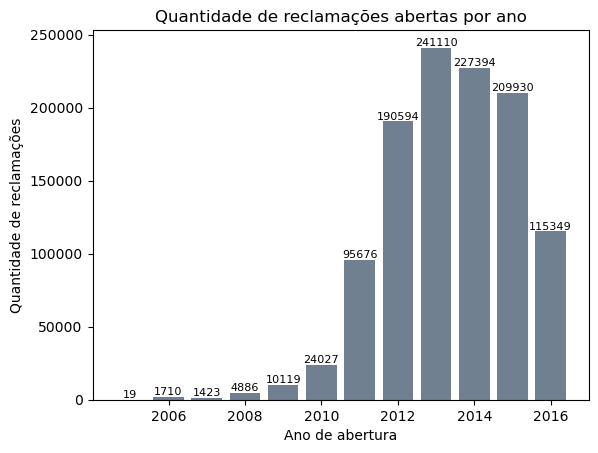

In [ ]:
# analisando a quantidade de reclamações por ano de abertura
reclamacoes_por_ano = df['AnoAbertura'].value_counts().sort_index()
df_por_ano = reclamacoes_por_ano.to_frame().reset_index()
df_por_ano = df_por_ano.rename(columns={'index': 'AnoAbertura', 'AnoAbertura': 'Quantidade'})

# gráfico de barras da quantidade de reclamações por ano
ax_reclamacoes_por_ano = plt.bar(df_por_ano.AnoAbertura, df_por_ano.Quantidade, color='slategrey')
plt.title("Quantidade de reclamações abertas por ano")
plt.xlabel("Ano de abertura")
plt.ylabel("Quantidade de reclamações")
plt.bar_label(ax_reclamacoes_por_ano, size=8, label_type="edge")

Visto que na base de dados analisada contém apenas as reclamações quanto a data de arquivamento (2012 a 2016), é possível observar uma discrepância quanto a quantidade de reclamações para os anos mais antigos. Provavelmente muitas reclamações abertas entre 2005 e 2011 não estão contempladas nessa análise, por terem sido arquivadas nos anos anteriores.
Assim como há reclamações recentes que não foram fechadas, por isso não estão inseridas nessa base de dados.

Sendo assim, algumas análises serão focadas nos anos de 2012 a 2016, para que não haja uma falsa interpretação dos dados.

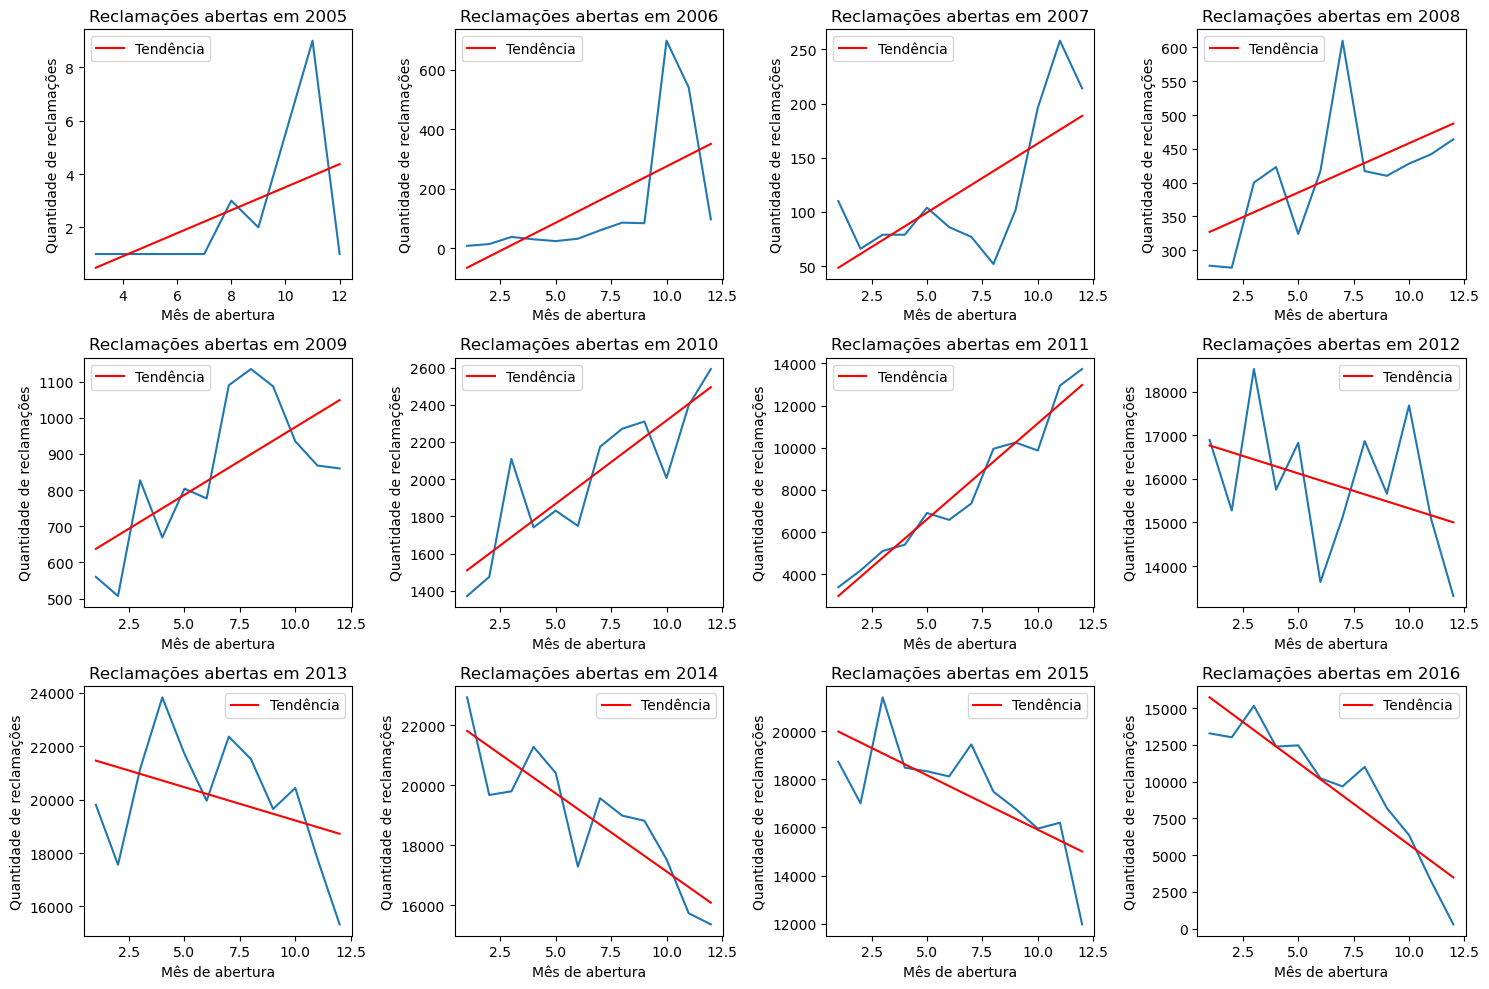

In [ ]:
# comparando TODOS os anos que tiveram abertura de reclamações

def plot_reclamacoes_por_ano(df):
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    # converter a matriz de subplots em um vetor 1D, o que facilita a iteração sobre eles usando um loop.
    axs = axs.ravel()
    for i, ano in enumerate(range(2005, 2017)):
        reclamacoes_por_mes = df.loc[df['AnoAbertura'] == ano, 'MêsAbertura'].value_counts().sort_index()
        # convertendo o resultado correspondente com o to_frame
        reclamacoes_ano = reclamacoes_por_mes.to_frame().reset_index().rename(columns={'index': 'MêsAbertura', 'MêsAbertura': 'Quantidade'})
        x = reclamacoes_ano.MêsAbertura
        y = reclamacoes_ano.Quantidade
        axs[i].plot(x, y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        axs[i].plot(x, p(x), "r-", label='Tendência')
        axs[i].set_title(f"Reclamações abertas em {ano}")
        axs[i].set_xlabel("Mês de abertura")
        axs[i].set_ylabel("Quantidade de reclamações")
        axs[i].legend()
    plt.tight_layout()
    plt.show()

plot_reclamacoes_por_ano(df)

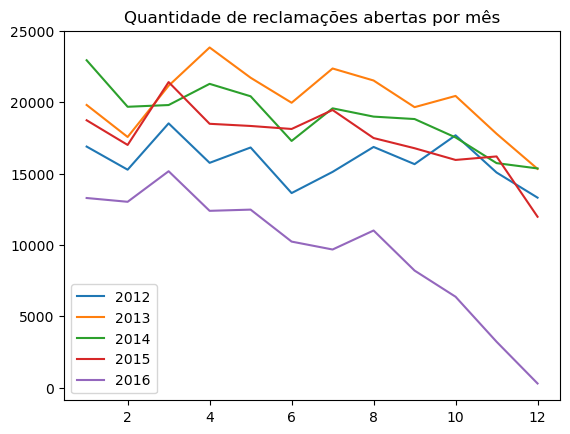

In [ ]:
counts = df.value_counts('DataAbertura')
df_temp = counts.reset_index().rename(columns={0: 'Reclamacoes'})
df_temp = df_temp.sort_values('DataAbertura').reset_index(drop=True)
df_temp['MêsAbertura'] = df_temp['DataAbertura'].dt.month
df_temp['AnoAbertura'] = df_temp['DataAbertura'].dt.year
# Filtrando reclamações entre 2012 e 2016
df_temp = df_temp[df_temp['AnoAbertura'].between(2012, 2016)]

# Somando as reclamações por Mês e Ano
agrupado = df_temp.groupby(['AnoAbertura', 'MêsAbertura'])[['Reclamacoes']].sum()
# Transformando as colunas 'AnoCalendario' em colunas separadas
desagrupado = agrupado.unstack(level=0)
desagrupado = desagrupado.fillna(0)

# Criando lista com valores únicos da coluna AnoAbertura
anos = list(desagrupado.columns.get_level_values('AnoAbertura').unique())

# Plotando uma curva para cada AnoCalendario
for i, coluna in enumerate(desagrupado.columns):
    plt.plot(desagrupado.index, desagrupado[coluna], label=anos[i])

plt.title('Quantidade de reclamações abertas por mês')
plt.legend()
plt.show()

Entre os anos de 2005 e 2011 é possível notar uma tendência de crescimento no número de abertura de reclamações ao longo dos meses. Com picos no último trimestre quanto aos anos de 2005 a 2007.

Já entre os anos de 2012 e 2016 notamos uma tendência de queda durante o ano, isso pode ser decorrente do fato de que muitas reclamações abertas em 2012 e nos anos seguintes não estão contempladas nessa análise, por não terem sido arquivadas ainda.
Além disso, observa-se uma diminuição pontual nos meses de junho e dezembro, e aumento nos meses de março e julho. 


## 2. Qual o tempo médio de uma reclamação ativa (da abertura até a data de fechamento)?

In [ ]:
# Criar a coluna com o tempo da resolução
df['TempoParaFechamento'] = (df['DataArquivamento'] - df['DataAbertura']).dt.days
# Entendendo a coluna criada
df['TempoParaFechamento'].describe().round()

count    1122237.0
mean         221.0
std          337.0
min          -18.0
25%           46.0
50%           98.0
75%          226.0
max         3975.0
Name: TempoParaFechamento, dtype: float64

Pelo valor mínimo, observa-se que tem dados negativos.

In [ ]:
# Listando estes dados
df[df['TempoParaFechamento'] < 0][['DataAbertura', 'DataArquivamento', 'strRazaoSocial']]

,DataAbertura,DataArquivamento,strRazaoSocial
246141,2013-06-04 10:12:40,2013-06-01,ponto friocom comercio eletronico
246908,2013-06-04 10:12:40,2013-06-01,caixa economica federal
274063,2013-02-18 14:47:36,2013-02-01,celesc distribuicao
347804,2013-02-06 17:38:07,2013-02-01,tnl pc
385132,2013-02-05 17:22:29,2013-02-01,vila brasil distribuidora manufaturados
447938,2013-02-14 14:23:07,2013-02-01,banco brasil
482728,2014-06-03 15:23:46,2014-06-01,casas bahia comercial
482729,2014-06-03 15:23:46,2014-06-01,cemaz industria eletronica amazonia
694608,2014-06-03 16:02:40,2014-06-01,laura maria bitencourt


Todos os registros com intervalos negativos foram arquivados no primeiro dias do mês de abertura. Isso pode ser devido a um padrão do sistema, ou erro humano, por exemplo. Como a quantidade é insignificante e não é possível determinar a data correta, vamos descartar esses registros.

In [ ]:
df = df[df['TempoParaFechamento'] >= 0]

In [ ]:
print(f"O tempo médio que uma reclamação fica ativa é de {round(df['TempoParaFechamento'].mean())} dias")

O tempo médio que uma reclamação fica ativa é de 221 dias


In [ ]:
# criando um dataframe só com reclamações abertas entre 2012 e 2016
df_filtrado = df.loc[(df['AnoAbertura'] >= 2012) & (df['AnoAbertura'] <= 2016)]

# calcular as medias
media_fechamento_geral = df.TempoParaFechamento.mean()
media_fechamento = df.groupby('Atendida')['TempoParaFechamento'].mean()
media_fechamento_geral2 = df_filtrado.TempoParaFechamento.mean()
media_fechamento2 = df_filtrado.groupby('Atendida')['TempoParaFechamento'].mean()
# criar o dataframe
df_medias = pd.DataFrame({'Geral': media_fechamento_geral, 'Atendidas': media_fechamento['Sim'], 'Não atendidas': media_fechamento['Não'] }, index=['Média'])
df_medias = df_medias.append(pd.DataFrame({'Geral': media_fechamento_geral2, 'Atendidas': media_fechamento2['Sim'], 'Não atendidas': media_fechamento2['Não'] }, index=['Média (2012 a 2016)']))
# calcular as medianas
mediana_fechamento_geral = df.TempoParaFechamento.median()
mediana_fechamento = df.groupby('Atendida')['TempoParaFechamento'].median()
mediana_fechamento_geral2 = df_filtrado.TempoParaFechamento.median()
mediana_fechamento2 = df_filtrado.groupby('Atendida')['TempoParaFechamento'].median()
# criar um novo DataFrame com a nova linha adicionada
df_medias = df_medias.append(pd.DataFrame({'Geral': mediana_fechamento_geral, 'Atendidas': mediana_fechamento['Sim'], 'Não atendidas': mediana_fechamento['Não']}, index=['Mediana']))
df_medias = df_medias.append(pd.DataFrame({'Geral': mediana_fechamento_geral2, 'Atendidas': mediana_fechamento2['Sim'], 'Não atendidas': mediana_fechamento2['Não']}, index=['Mediana (2012 a 2016)']))
# arredondando 
df_medias = df_medias.astype(int)
df_medias


C:\Users\lnune\AppData\Local\Temp\ipykernel_26172\492973287.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_medias = df_medias.append(pd.DataFrame({'Geral': media_fechamento_geral2, 'Atendidas': media_fechamento2['Sim'], 'Não atendidas': media_fechamento2['Não'] }, index=['Média (2012 a 2016)']))
C:\Users\lnune\AppData\Local\Temp\ipykernel_26172\492973287.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_medias = df_medias.append(pd.DataFrame({'Geral': mediana_fechamento_geral, 'Atendidas': mediana_fechamento['Sim'], 'Não atendidas': mediana_fechamento['Não']}, index=['Mediana']))
C:\Users\lnune\AppData\Local\Temp\ipykernel_26172\492973287.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_medias = df_med

,Geral,Atendidas,Não atendidas
Média,220,175,296
Média (2012 a 2016),148,131,180
Mediana,98,85,125
Mediana (2012 a 2016),83,76,98


In [ ]:
# criando um dataframe só com reclamações abertas entre 2012 e 2016
df_filtrado = df.loc[(df['AnoAbertura'] >= 2012) & (df['AnoAbertura'] <= 2016)]

# calculado
desvio_padrao_geral = df.TempoParaFechamento.std()
desvio_padrao = df.groupby('Atendida')['TempoParaFechamento'].std()
desvio_padrao_geral2 = df_filtrado.TempoParaFechamento.std()
desvio_padrao2 = df_filtrado.groupby('Atendida')['TempoParaFechamento'].std()
# criar o dataframe
df_desvio_padrao = pd.DataFrame({'Geral': desvio_padrao_geral, 'Atendidas': desvio_padrao['Sim'], 'Não atendidas': desvio_padrao['Não'] }, index=['Desvio Padrão'])
df_desvio_padrao = df_desvio_padrao.append(pd.DataFrame({'Geral': desvio_padrao_geral2, 'Atendidas': desvio_padrao2['Sim'], 'Não atendidas': desvio_padrao2['Não'] }, index=['Desvio Padrão (2012 a 2016)']))
# arredondando 
df_desvio_padrao = df_desvio_padrao.astype(int)
df_desvio_padrao

C:\Users\lnune\AppData\Local\Temp\ipykernel_26172\2338746746.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_desvio_padrao = df_desvio_padrao.append(pd.DataFrame({'Geral': desvio_padrao_geral2, 'Atendidas': desvio_padrao2['Sim'], 'Não atendidas': desvio_padrao2['Não'] }, index=['Desvio Padrão (2012 a 2016)']))


,Geral,Atendidas,Não atendidas
Desvio Padrão,336,260,424
Desvio Padrão (2012 a 2016),187,159,226


Text(0.5, 1.0, 'Média e Mediana de tempo para fechamento')

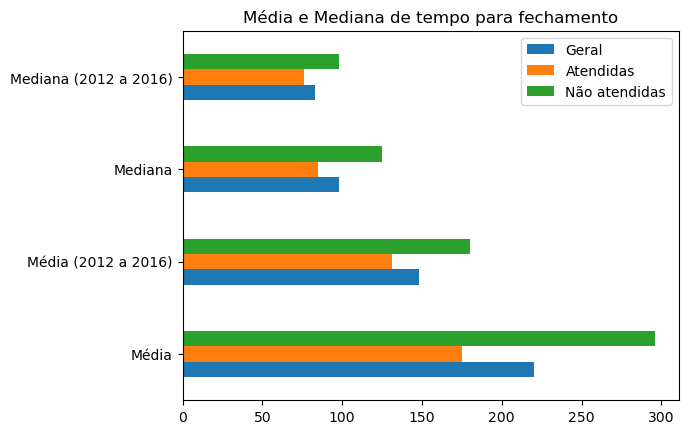

In [ ]:
df_medias.plot(kind='barh').set_title('Média e Mediana de tempo para fechamento')

Text(0.5, 1.0, 'Histograma de tempo para fechamento das reclamações')

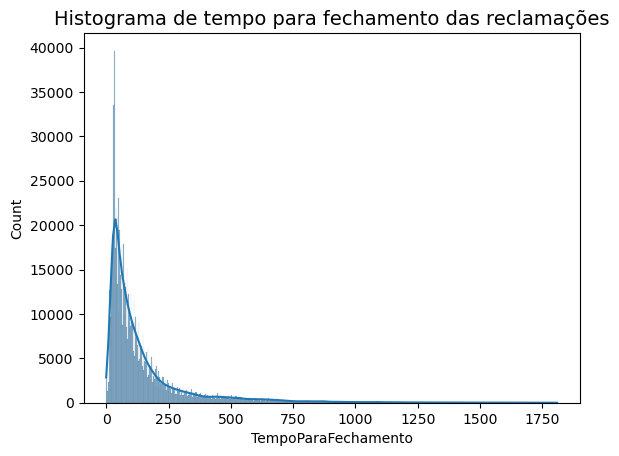

In [ ]:
hist_dias_fechamento = sns.histplot(df_filtrado['TempoParaFechamento'], kde=True)
hist_dias_fechamento.set_title("Histograma de tempo para fechamento das reclamações", fontsize=14)


<AxesSubplot:title={'center':'Boxplot do tempo de fechamento por ano de abertura'}, xlabel='AnoAbertura', ylabel='TempoParaFechamento'>

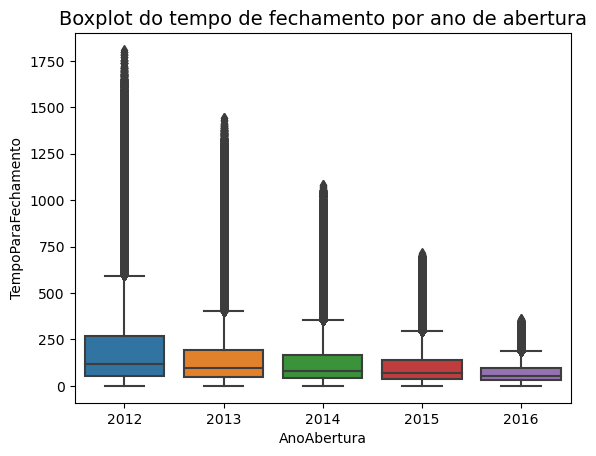

In [ ]:
boxplot_dias_fechamento = sns.boxplot(y = 'TempoParaFechamento', x = 'AnoAbertura', data=df.query('AnoAbertura>2011<2017'))
boxplot_dias_fechamento.set_title("Boxplot do tempo de fechamento por ano de abertura", fontsize=14)
boxplot_dias_fechamento

## Analisando quanto ao atendimento das reclamações

In [ ]:
frequencia_atendida = df['Atendida'].value_counts()
percentual_atendida = df['Atendida'].value_counts(normalize=True)
atendidas = pd.DataFrame({'Quantidade': frequencia_atendida, 'Porcentagem (%)': percentual_atendida.round(2) * 100})
atendidas


,Quantidade,Porcentagem (%)
Sim,702852,63.0
Não,419376,37.0


Text(0.5, 1.0, 'Proporção de reclamações atendidas')

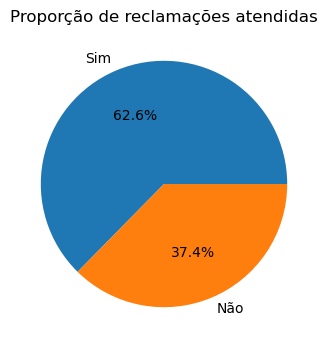

In [ ]:
plt.figure(figsize =(7, 4))
plt.pie(frequencia_atendida, labels=frequencia_atendida.index, autopct='%1.1f%%')
plt.title('Proporção de reclamações atendidas')

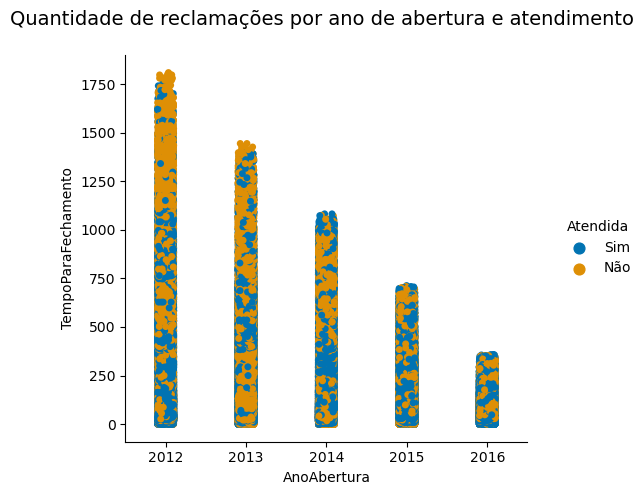

In [ ]:
ax_box_atend = sns.catplot(x='AnoAbertura', y='TempoParaFechamento', hue='Atendida', data=df_filtrado, palette = "colorblind")
ax_box_atend.fig.suptitle("Quantidade de reclamações por ano de abertura e atendimento", fontsize=14)
ax_box_atend.fig.subplots_adjust(top=0.89)

A mediana e a média, e também o desvio padrão considerando apenas de 2012 a 2016 é menor do que a de todos os anos, devido aos casos das reclamações que foram abertas em anos muito anteriores.

A média de tempo é de 220 dias, e a mediana é de 98 dias. Além disso, o histograma apresenta comportamento de assimetria a direita. Ou seja, mesmo restringindo a análise para os anos de 2012 a 2016, existe uma quantidade de reclamaçãos com tempo para fechamento muito altos gerando essa assimetria, o que causa essa diferença grande entre a média e a mediana.

Desta forma, Visto que os dados tem uma distribuição de forma mais heterogênea e com um número menor fugido ao padrão, será considerado que o temo médio de fechamento é de 98 dias.

Realizando uma análise anual através do boxplot acima, foi observado que os anos possuem a mediana próxima, porém ao longo dos anos a variação do tempo diminuiu. Assim como a quantidade de outliers. Este comportamento ocorre pois há reclamações dos anos recentes que ainda não foram fechadas, e com isso não estão contempladas na base de dados.

Também foi observado que a quantidade de reclamações não atendidas é bastante alta. No ano de 2012, por exemplo, há muitas reclamações que foram fechadas acima de 1000 dias depois e ainda assim não foram atendidas.





# E quanto ao tempo médio para fechamentos? Será que existe sazonalidade?

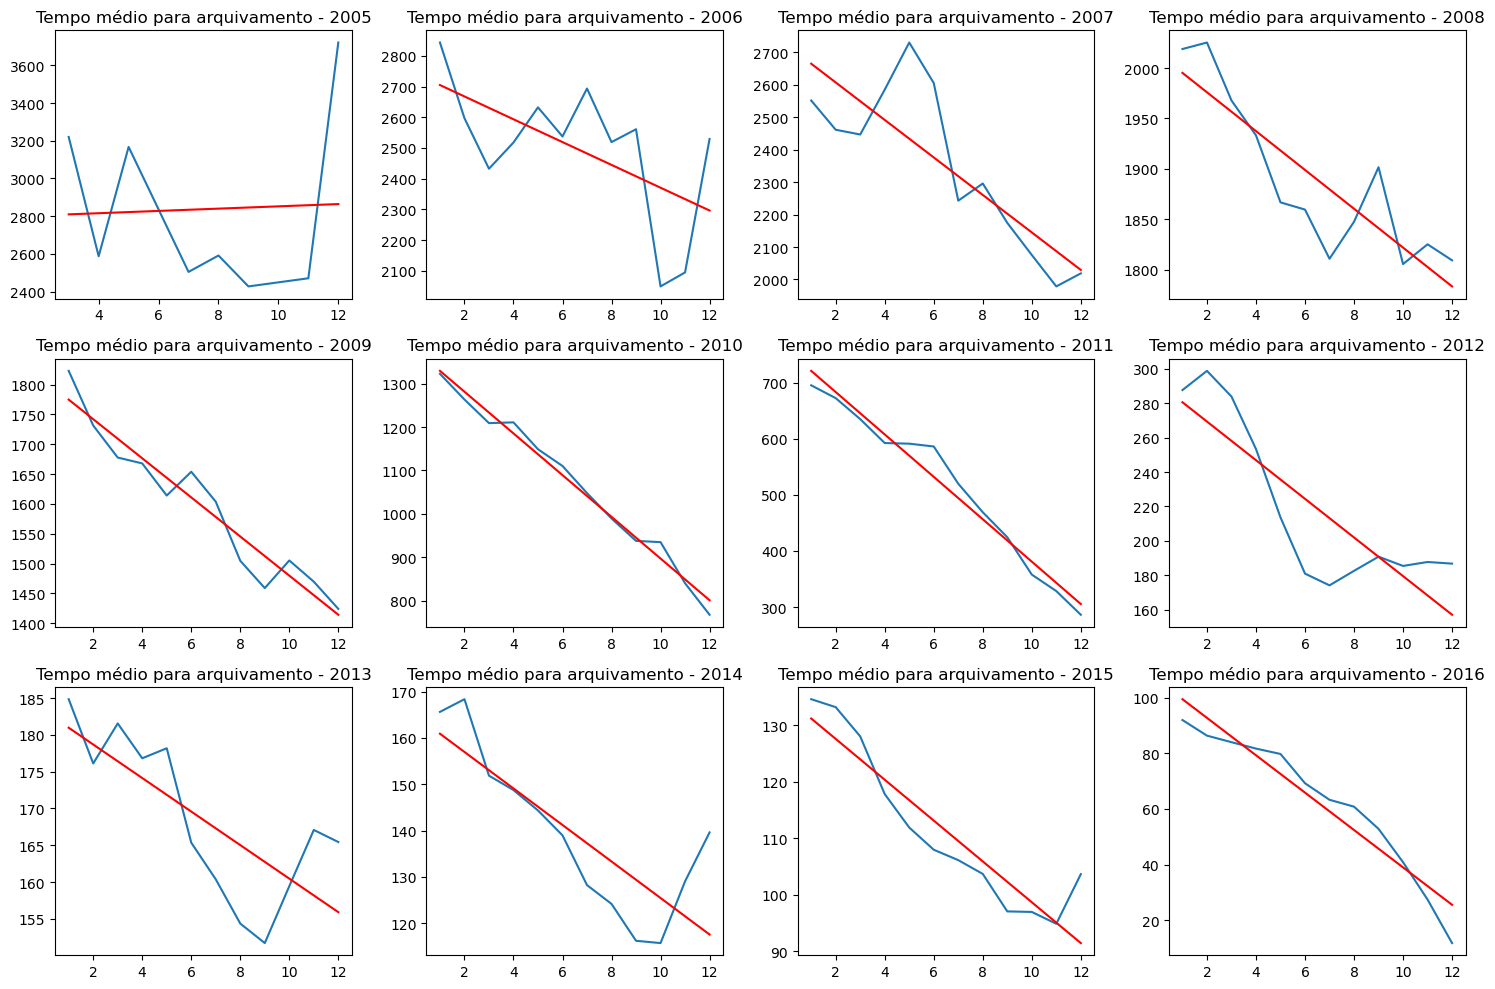

In [ ]:
# Criação do subplot
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Loop pelos anos e índices do subplot
for i, ano in enumerate(sorted(df['AnoAbertura'].unique())):
    # Seleciona o subplot correspondente
    ax = axs[i // 4, i % 4]

    # Cálculo dos dados para o gráfico
    df_temp = df[df['AnoAbertura'] == ano].groupby('MêsAbertura')['TempoParaFechamento'].mean().reset_index()

    # Plotagem do gráfico no subplot
    ax.plot(df_temp['MêsAbertura'], df_temp['TempoParaFechamento'])
    ax.set_title(f"Tempo médio para arquivamento - {ano}")

    # Adição da linha de tendência
    z = np.polyfit(df_temp['MêsAbertura'], df_temp['TempoParaFechamento'], 1)
    p = np.poly1d(z)
    ax.plot(df_temp['MêsAbertura'], p(df_temp['MêsAbertura']), "-", color='red')

# Ajuste de layout e exibição dos subplots
plt.tight_layout()
plt.show()

# for ano in sorted(df['AnoAbertura'].unique()):
#     df_temp = df[df['AnoAbertura'] == ano].groupby('MêsAbertura')['TempoParaFechamento'].mean().reset_index()
#     plt.plot(df_temp['MêsAbertura'], df_temp['TempoParaFechamento'])

#     plt.title(f"Tempo médio para arquivamento longo de {ano}")
#     plt.show()

A partir dos gráficos percebe-se que reclamações abertas no início dos anos têm um tempo médio de aquivamento maior quando comparadas com as que são abertas no restante do anos.

### 3. O número de reclamações varia de acordo com a região? E de acordo com o estado? E se ponderarmos pela população média do estado?

Por região temos:

In [ ]:
# Reclamações por região
frequencia_regiao = df['Regiao'].value_counts()
percentual_regiao = df['Regiao'].value_counts(normalize=True)
df_regiao = pd.DataFrame({'Quantidade': frequencia_regiao, 'Porcentagem(%)': percentual_regiao.round(2) * 100})
df_regiao = df_regiao.reset_index().rename(columns={'index': 'Regiao'})
df_regiao

,Regiao,Quantidade,Porcentagem(%)
0,Sudeste,399667,36.0
1,Nordeste,368054,33.0
2,Centro-oeste,180207,16.0
3,Sul,95669,9.0
4,Norte,78631,7.0


Text(0.5, 1.0, 'Proporção de reclamações por região')

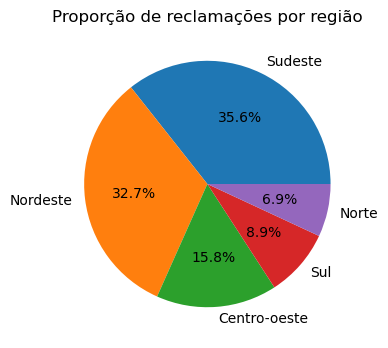

In [ ]:
plt.figure(figsize =(7, 4))
plt.pie(df_regiao['Porcentagem(%)'], labels=df_regiao.Regiao, autopct='%1.1f%%')
plt.title('Proporção de reclamações por região')

In [ ]:
# Ponderando pela população média da região
pop_regiao = df_populacao.groupby('Regiao')['Populacao'].sum()
df_regiao = pd.merge(df_regiao, pop_regiao.reset_index().rename(columns={'index': 'Regiao'}), on='Regiao')
df_regiao['Reclamacoes_por_pessoa'] = (df_regiao['Quantidade']/df_regiao['Populacao'])*100
df_regiao = df_regiao.sort_values('Reclamacoes_por_pessoa', ascending=False)
df_regiao

,Regiao,Quantidade,Porcentagem(%),Populacao,Reclamacoes_por_pessoa
2,Centro-oeste,180207,16.0,15660988,1.150675
1,Nordeste,368054,33.0,56915936,0.646662
0,Sudeste,399667,36.0,86356952,0.462808
4,Norte,78631,7.0,17707783,0.444048
3,Sul,95669,9.0,29439773,0.324965


Por estado temos:

In [ ]:
# Cálculo das reclamações por estado
frequencia_UF = df['UF'].value_counts()
percentual_UF = df['UF'].value_counts(normalize=True)
df_uf = pd.DataFrame({'Quantidade': frequencia_UF, 'Porcentagem(%)': percentual_UF.round(2) * 100})
df_uf = df_uf.reset_index().rename(columns={'index': 'UF'})
print('Os estados com mais reclamações são:')
df_uf.head(5)

Os estados com mais reclamações são:


,UF,Quantidade,Porcentagem(%)
0,SP,193219,17.0
1,PE,96555,9.0
2,BA,85539,8.0
3,MG,77233,7.0
4,ES,70667,6.0


[Text(0, 0, '193219'),
 Text(0, 0, '96555'),
 Text(0, 0, '85539'),
 Text(0, 0, '77233'),
 Text(0, 0, '70667')]

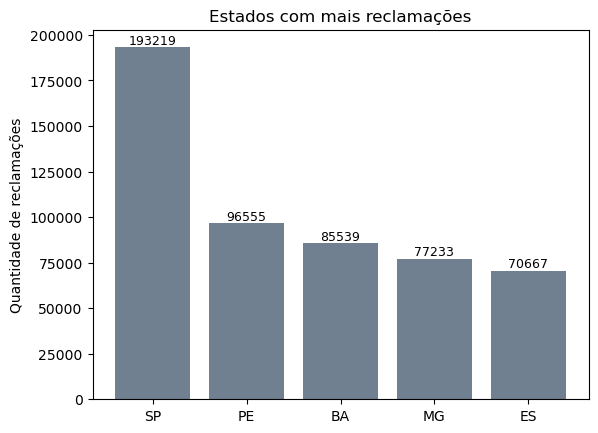

In [ ]:
df_uf_top5 = df_uf.head(5)
ax_uf = plt.bar(df_uf_top5['UF'], df_uf_top5['Quantidade'], color='slategrey')
plt.title("Estados com mais reclamações")
plt.ylabel("Quantidade de reclamações")
plt.bar_label(ax_uf, size=9, label_type="edge")

In [ ]:
# Merge com df_populacao
df_uf = pd.merge(df_uf, df_populacao[['UF', 'Populacao']], on='UF')
df_uf.sort_values('Quantidade', ascending=False)
# Calculo das reclamacoes ponderadas
df_uf['Reclamacoes_por_pessoa'] = (df_uf['Quantidade']/df_uf['Populacao'])*100
df_uf = df_uf.sort_values('Reclamacoes_por_pessoa', ascending=False)
print('Os estados com mais recamações per capita são:')
df_uf.head(5)

Os estados com mais recamações per capita são:


,UF,Quantidade,Porcentagem(%),Populacao,Reclamacoes_por_pessoa
5,MS,69428,6.0,2682386,2.588293
12,TO,35026,3.0,1532902,2.284947
4,ES,70667,6.0,3973697,1.778369
9,AL,47214,4.0,3358963,1.405612
11,MT,42564,4.0,3305531,1.287660


A região sudeste é a que contém maior quantidade de reclamações, liderada pelo estado de São Paulo, porém quando realizada análise per capita, a região Centro-Oeste está a frente das demais, com o estado Mato Grosso do Sul tomando o 1º lugar.


### 4. Quais as empresas que receberam mais reclamações dos consumidores? E por região?E por estado?

#### CLassificação CNAE

In [ ]:
frequencia_classificacao = df['DescCNAEPrincipal'].value_counts()
percentual_classificacao = df['DescCNAEPrincipal'].value_counts(normalize=True)
df_classificacao = pd.DataFrame({'Quantidade': frequencia_classificacao, 'Porcentagem (%)': percentual_classificacao * 100})
df_classificacao.head(5)

,Quantidade,Porcentagem (%)
bancos multiplos carteira comercial,120249,10.715202
telefonia movel celular,84399,7.520664
comercio varejista especializado eletrodomesticos equipamentos audio video,67955,6.055365
servicos telefonia fixa comutada stfc,60104,5.355774
lojas departamentos magazine,35246,3.140717


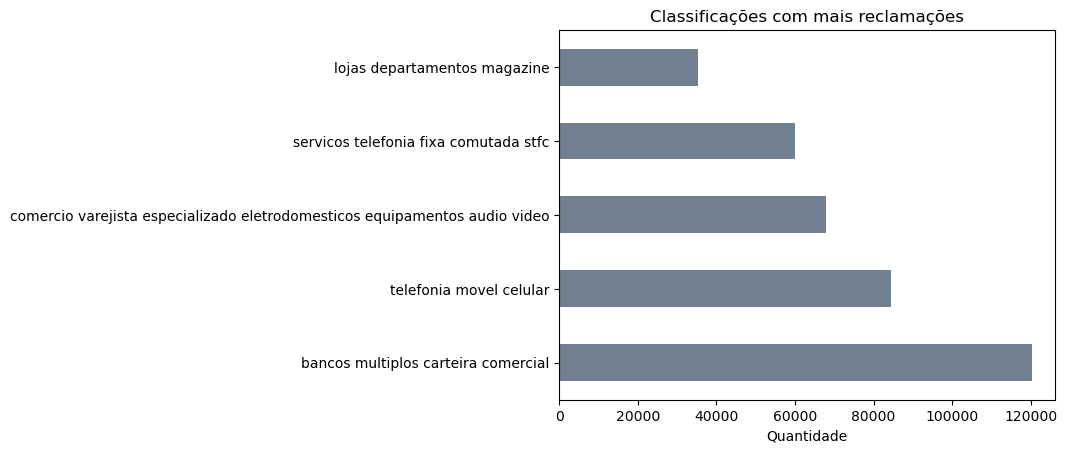

In [ ]:
# Seleção dos 5 primeiros registros
df_classificacao_top5 = df_classificacao.head(5)

# Plotagem do gráfico de barras horizontais
ax = df_classificacao_top5['Quantidade'].plot(kind='barh', color='slategrey')

# Configurações do gráfico
ax.set_title("Classificações com mais reclamações")
ax.set_xlabel("Quantidade")

# Exibição do gráfico
plt.show()


#### Razão Social

In [ ]:
frequencia_razao_social = df['strRazaoSocial'].value_counts()
percentual_razao_social = df['strRazaoSocial'].value_counts(normalize=True)
df_razao_social = pd.DataFrame({'Quantidade': frequencia_razao_social, 'Porcentagem (%)': percentual_razao_social * 100})
df_razao_social.head(10)

,Quantidade,Porcentagem (%)
telemar norte leste,22882,2.038980
claro,19388,1.727635
samsung eletronica amazonia,19066,1.698942
sky brasil servicos,16263,1.449171
tim celular,15861,1.413349
via varejo,13773,1.227291
caixa economica federal,13265,1.182024
banco bmg,12502,1.114034
oi movel,11314,1.008173
telefonica brasil,11283,1.005411


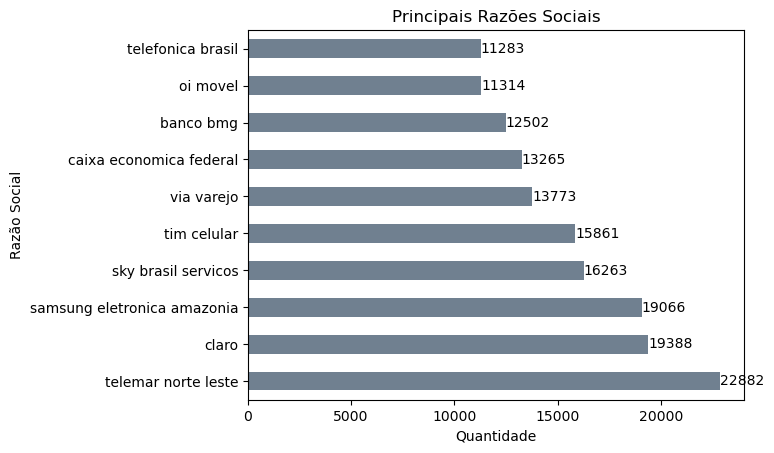

In [ ]:
df_razao_social_top10 = df_razao_social.head(10)
# Plotagem do gráfico de barras horizontais
ax = df_razao_social_top10['Quantidade'].plot(kind='barh', color='slategrey')

# Configurações do gráfico
ax.set_title("Principais Razões Sociais")
ax.set_xlabel("Quantidade")
ax.set_ylabel("Razão Social")

# Adicionar rótulos de dados dentro de cada barra
for i, v in enumerate(df_razao_social_top10['Quantidade']):
    ax.text(v - 10, i, str(v), color='black', va='center')

# Exibição do gráfico
plt.show()

Por região:

In [ ]:
# Calcular a quantidade total de reclamações por região
counts_regiao = df['Regiao'].value_counts()

# Ocorrências de cada strRazaoSocial por região
counts = df.groupby('Regiao')['strRazaoSocial'].value_counts()

# strRazaoSocial mais comum em cada grupo
top_empresas = counts.groupby(level=0).idxmax()
top_empresas_qdt = counts.groupby(level=0).max()

# DataFrame com as informações
df_resultado = pd.DataFrame({'Regiao': top_empresas.index.get_level_values(0), # Seleciona só o nome da região
                             'Empresa': top_empresas.apply(lambda x: x[1]), # Seleciona só o nome da empresa
                             'Reclamacoes': top_empresas_qdt.values}).reset_index(drop=True)

# Calcular a porcentagem das reclamações de cada empresa em relação ao total de reclamações da região correspondente
df_resultado['Porcentagem(%)'] = df_resultado.apply(lambda x: round((x['Reclamacoes'] / counts_regiao[x['Regiao']]) * 100, 2), axis=1)

# Ordenar o DataFrame pelo número de reclamações em ordem decrescente
df_resultado.sort_values('Reclamacoes', ascending=False, inplace=True)
df_resultado


,Regiao,Empresa,Reclamacoes,Porcentagem(%)
3,Sudeste,telemar norte leste,11184,2.80
1,Nordeste,telemar norte leste,10530,2.86
0,Centro-oeste,americel,3573,1.98
4,Sul,oi,3505,3.66
2,Norte,centrais eletricas,2120,2.70


Da mesma forma para os estados

In [ ]:
# Calcular a quantidade total de reclamações por região
counts_UF = df['UF'].value_counts()

# Ocorrências de cada strRazaoSocial por região
counts = df.groupby('UF')['strRazaoSocial'].value_counts()

# strRazaoSocial mais comum em cada grupo
top_empresas = counts.groupby(level=0).idxmax()
top_empresas_qdt = counts.groupby(level=0).max()

# DataFrame com as informações
df_resultado = pd.DataFrame({'UF': top_empresas.index.get_level_values(0), # Seleciona só o nome da região
                             'Empresa': top_empresas.apply(lambda x: x[1]), # Seleciona só o nome da empresa
                             'Reclamacoes': top_empresas_qdt.values}).reset_index(drop=True)

# Calcular a porcentagem das reclamações de cada empresa em relação ao total de reclamações da região correspondente
df_resultado['Porcentagem(%)'] = df_resultado.apply(lambda x: round((x['Reclamacoes'] / counts_UF[x['UF']]) * 100, 2), axis=1)

# Ordenar o DataFrame pelo número de reclamações em ordem decrescente
df_resultado.sort_values('Reclamacoes', ascending=False, inplace=True)
df_resultado.head(10)


,UF,Empresa,Reclamacoes,Porcentagem(%)
24,SP,telefonica brasil,7824,4.05
10,MG,telemar norte leste,6616,8.57
18,RJ,via varejo,4330,7.40
7,ES,telemar norte leste,3954,5.60
4,BA,telemar norte leste,3895,4.55
15,PE,telemar norte leste oi fixo,3582,3.71
22,SC,oi,3505,5.90
5,CE,telemar norte leste,2363,5.41
11,MS,americel,2350,3.38
13,PA,centrais eletricas,2118,9.86


Também foi analisado o tempo para fechamento de reclamação por Região e por UF:

Por região o tempo médio é de:

In [ ]:
df.groupby('Regiao')['TempoParaFechamento'].mean().round().sort_values(ascending=False)

Regiao
Norte           461.0
Centro-oeste    293.0
Nordeste        215.0
Sul             164.0
Sudeste         159.0
Name: TempoParaFechamento, dtype: float64

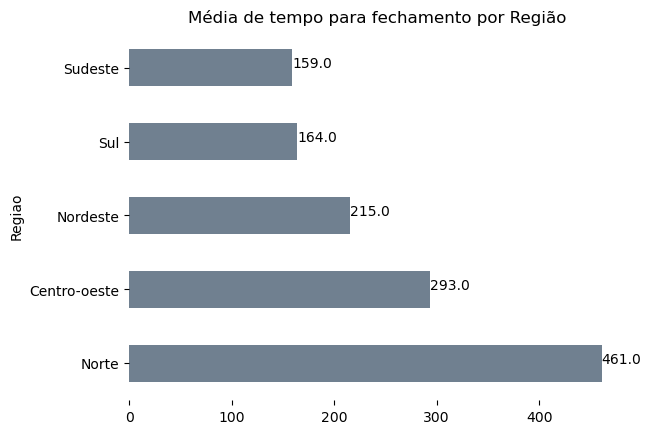

In [ ]:
df_tempo_regiao = df.groupby('Regiao')['TempoParaFechamento'].mean().round().sort_values(ascending=False)

ax = df_tempo_regiao.plot(kind='barh', color='slategrey')
ax.set_title('Média de tempo para fechamento por Região')
for i, v in enumerate(df_tempo_regiao):
    ax.text(v + 0.1, i, str(v), color='black')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)

plt.show()


Os estados com tempo médio maior são:

In [ ]:
df.groupby('UF')['TempoParaFechamento'].mean().round().sort_values(ascending=False)[:5]

UF
AP    1048.0
TO     677.0
RS     641.0
SE     627.0
DF     485.0
Name: TempoParaFechamento, dtype: float64

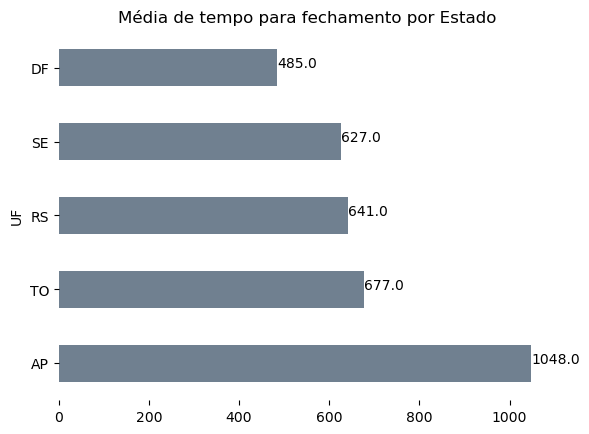

In [ ]:
df_tempo_estado = df.groupby('UF')['TempoParaFechamento'].mean().round().sort_values(ascending=False)[:5]
ax1 = df_tempo_estado.plot(kind='barh', color='slategrey')
ax1.set_title('Média de tempo para fechamento por Estado')

# Adiciona os rótulos de dados em cada barra
for i, v in enumerate(df_tempo_estado):
    ax1.text(v + 0.1, i, str(v), color='black')
    
# Remover delimitação dos eixos
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(0)
ax1.spines['left'].set_linewidth(0)

A empresa com mais reclamações no geral é a TELEMAR, representando 2,04% das reclamações totais.

Telemar aparece como empresa mais reclamada nas 2 primeiras regiões e no top 1 de em 4 dos 10 estados com mais reclamações.

A análise do tempo médio de fechamento de uma reclamação por Estado e Região nos retorna que a região norte é a mais impactada, principalmente o estado do Amapá.

Em compensação, as do Sudeste possuem menor média de tempo para fechamento, essa região possui mais atenção quanto a resolução de problemas, supõe-se que seja devido a proximidade e localização estratégica com as grandes empresas.

# E quanto ao sexo? E a idade?

In [ ]:
print(f"Reclamações por sexo:")
df_sexo = df['SexoConsumidor'].value_counts(normalize=True)*100
df_sexo.reset_index().rename(columns={'index': 'Sexo', 'SexoConsumidor': 'Ocorrências (%)'})

Reclamações por sexo:


,Sexo,Ocorrências (%)
0,Feminino,52.902886
1,Masculino,46.357959
2,N,0.653343
3,Não informado,0.085811


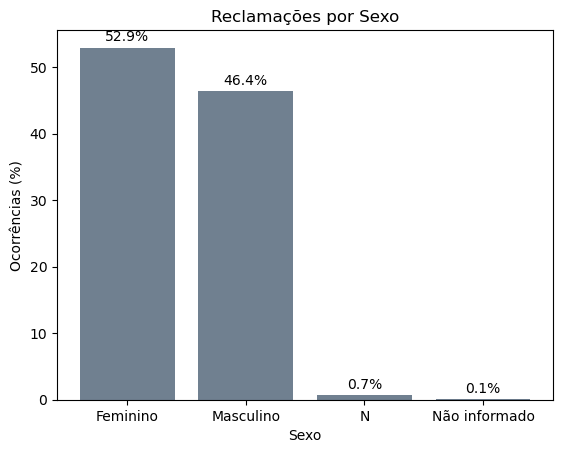

In [ ]:
# Plotagem do gráfico de barras verticais
plt.bar(df_sexo.index, df_sexo.values, color='slategrey')

# Adicionar rótulos de dados acima de cada barra
for i, v in enumerate(df_sexo.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', color='black')

# Configurações do gráfico
plt.title("Reclamações por Sexo")
plt.xlabel("Sexo")
plt.ylabel("Ocorrências (%)")


# Exibição do gráfico
plt.show()


In [ ]:
print(f"As faixas etarias que mais realizaram reclamações foram:")
df_idade = df['FaixaEtariaConsumidor'].value_counts(normalize=True)*100
df_idade.reset_index().rename(columns={'index': 'Faixa Etaria', 'FaixaEtariaConsumidor': 'Ocorrências (%)'})

As faixas etarias que mais realizaram reclamações foram:


,Faixa Etaria,Ocorrências (%)
0,entre 31 a 40 anos,22.686566
1,entre 41 a 50 anos,19.299554
2,entre 21 a 30 anos,16.732963
3,entre 51 a 60 anos,15.475019
4,entre 61 a 70 anos,10.111314
5,Nao Informada,8.822004
6,mais de 70 anos,4.848480
7,até 20 anos,1.959406
8,Nao se aplica,0.064693


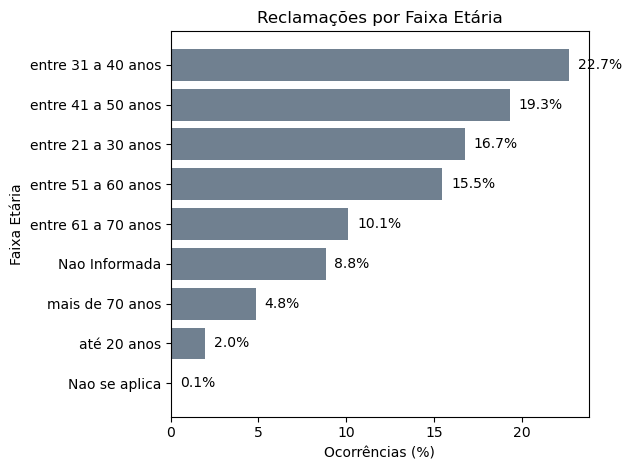

In [ ]:
plt.barh(df_idade.index, df_idade.values, color='slategrey')

# Adicionar rótulos de dados dentro de cada barra
for i, v in enumerate(df_idade.values):
    plt.text(v + 0.5, i, f'{v:.1f}%', ha='left', va='center', color='black')

plt.title("Reclamações por Faixa Etária")
plt.xlabel("Ocorrências (%)")
plt.ylabel("Faixa Etária")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Outras features

**strRazaoSocial**

Nome das empresas

In [ ]:
print('As empresas com maior tempo médio são:')
df.groupby('strRazaoSocial')['TempoParaFechamento'].mean().round(0).sort_values()[-5:].reset_index().rename(columns={'strRazaoSocial':'Empresa', 'TempoParaFechamento': 'Qtd. média de dias'})

As empresas com maior tempo médio são:


,Empresa,Qtd. média de dias
0,sky escola informatica idiomas,3795.0
1,nmr santos,3798.0
2,tectel comercio equipamentos comunicacao,3801.0
3,j assuncao filho,3862.0
4,alcyrus v p barreto sc,3924.0


**DescricaoAssunto**

In [ ]:
print('Os assuntos com maiores médias de dias são:')
df.groupby('DescricaoAssunto')['TempoParaFechamento'].mean().round(0).sort_values()[-5:].reset_index().rename(columns={'DescCNAEPrincipal':'CNEA', 'TempoParaFechamento': 'Qtd. média de dias'})

Os assuntos com maiores médias de dias são:


,DescricaoAssunto,Qtd. média de dias
0,especiarias condimentos oregano pimenta cravo ...,666.0
1,fermento po biologico,696.0
2,temperos prontos ajinomoto sal alho etc,933.0
3,balanca informacao nutricional valor calorico ...,1009.0
4,farinaceos fuba polvilho etc,1084.0


In [ ]:
print(f"Os assuntos mais frequentes são:")
df['DescricaoAssunto'].value_counts().sort_values(ascending=False)[:5].reset_index().rename(columns={'index': 'Assunto', 'DescricaoAssunto': 'Ocorrências'})

Os assuntos mais frequentes são:


,Assunto,Ocorrências
0,telefone convencional celular interfone etc,113951
1,telefonia celular,73387
2,microcomputador produtos informatica,68269
3,banco comercial,65715
4,telefonia fixa plano expansao compra venda loc...,65505


**DescricaoProblema**

In [ ]:
print('Os problemas com maiores médias de dias são:')
df.groupby('DescricaoProblema')['TempoParaFechamento'].mean().round(0).sort_values()[-5:].reset_index().rename(columns={'DescricaoProblema':'Problema', 'TempoParaFechamento': 'Qtd. média de dias'})

Os problemas com maiores médias de dias são:


,Problema,Qtd. média de dias
0,produto nao atende finalidade especifica carti...,534.0
1,presenca aditivos produtos quimicos toxicos ra...,568.0
2,prazo validade falta ilegivel etc,648.0
3,duvidas sobre informacao nutricional avaliacao...,763.0
4,produto nao possui registro registro falso num...,1039.0


In [ ]:
print(f"Os Problemas mais frequentes são:")
df['DescricaoProblema'].value_counts().sort_values(ascending=False)[:5].reset_index().rename(columns={'index': 'Problema', 'DescricaoProblema': 'Ocorrências'})

Os Problemas mais frequentes são:


,Problema,Ocorrências
0,produto vicio,232418
1,cobranca indevidaabusiva,171541
2,garantia abrangencia cobertura etc,118402
3,cobranca indevida,88128
4,nao entregademora entrega produto,52571


**SexoConsumidor**


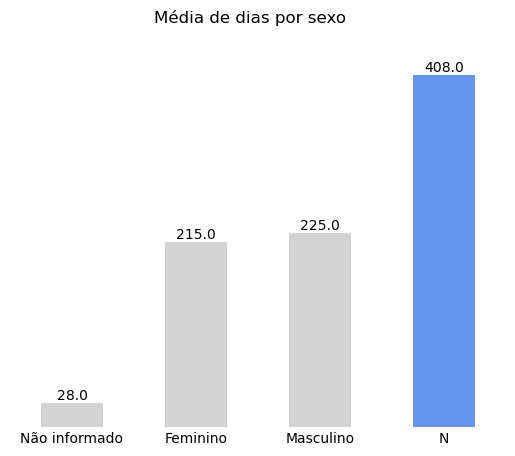

In [ ]:
counts = df.groupby('SexoConsumidor')['TempoParaFechamento'].mean().round(0).sort_values()
colors = ['lightgrey'] * len(counts.index)  # lista com cores cinzas claras
colors[np.argmax(counts.values)] = '#6495ED'  # definindo a cor da barra com o maior valor

# Plotar o gráfico de barras
ax = counts.plot.bar(color=colors)

# Adicionar título e legenda para os eixos
plt.suptitle("Média de dias por sexo", fontsize=12)

# Remover delimitação dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)

# Remover legendas do eixo y
ax.set_yticklabels([])


ax.set_xlabel('')
# Remover traços do eixo x e y
ax.tick_params(axis='both', length=0, width=0, rotation=0)

# Adicionar valores acima das barras com mais espaço
for i, v in enumerate(counts.values):
    ax.text(i, v+0.2, str(v), ha='center', va='bottom')

# Exibir o gráfico
plt.show()

**FaixaEtariaConsumidor**


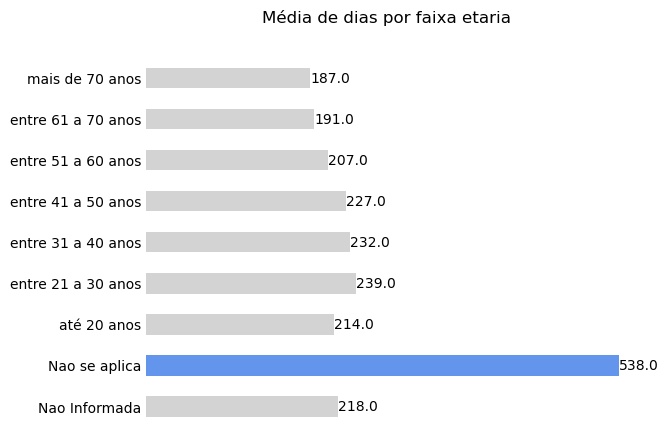

In [ ]:
counts = df.groupby('FaixaEtariaConsumidor')['TempoParaFechamento'].mean().round(0)
colors = ['lightgrey'] * len(counts.index)  # lista com cores cinzas claras
colors[np.argmax(counts.values)] = '#6495ED'  # definindo a cor da barra com o maior valor

# Plotar o gráfico de barras na horizontal
ax = counts.plot.barh(color=colors)

# Adicionar título e legenda para os eixos
plt.suptitle("Média de dias por faixa etaria", fontsize=12)

# Remover delimitação dos eixos
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)

# Remover legendas do eixo y
ax.set_xticklabels([])

ax.set_ylabel('')

# Remover traços do eixo x e y
ax.tick_params(axis='both', length=0, width=0, rotation=0)

# Adicionar valores ao lado das barras com mais espaço
for i, v in enumerate(counts.values):
    ax.text(v+0.2, i, str(v), ha='left', va='center')

# Exibir o gráfico
plt.show()

# Modelo

Como prever se uma reclamação será solucionada?
Quantos dias para uma reclamação ser solucionasa?

2. Modelagem: Prevendo o tempo de uma reclamação ativa
    1. Quais as variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa?
    2. Construa variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa a partir dos dados. Exemplo. crie variáveis dummy referentes ao período do ano, região, etc.
    3. Análise a correlação entre as variáveis.
    4. Construa um modelo de regreção linear em que queremos estimar o tempo de uma reclamação ativa.

1. Quais as variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa? A partir da análise exploratória

Considerando a análise da sazonalidade e do tempo médio acreditamos que as seguintes variáveis podem estar correlacionadas:
- Ano abertura
- MesAbertura
- Regiao
- UF
- DescricaoAssunto
- DescricaoProblema
- strRazaoSocial
- FaixaEtariaConsumidor

2. Construa variáveis que podem estar correlacionadas com o tempo de uma reclamação ativa a partir dos dados. Exemplo. crie variáveis dummy referentes ao período do ano, região, etc.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122228 entries, 0 to 1122236
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   AnoCalendario          1122228 non-null  int32         
 1   DataArquivamento       1122228 non-null  datetime64[ns]
 2   DataAbertura           1122228 non-null  datetime64[ns]
 3   Regiao                 1122228 non-null  object        
 4   UF                     1122228 non-null  object        
 5   strRazaoSocial         1122228 non-null  object        
 6   Tipo                   1122228 non-null  int64         
 7   DescCNAEPrincipal      1122228 non-null  object        
 8   Atendida               1122228 non-null  object        
 9   DescricaoAssunto       1122228 non-null  object        
 10  DescricaoProblema      1122228 non-null  object        
 11  SexoConsumidor         1122228 non-null  object        
 12  FaixaEtariaConsumidor  11222

In [ ]:
for col in df.columns:
    print(f"{col} tem {df[col].nunique()} valores únicos.\n")

AnoCalendario tem 5 valores únicos.

DataArquivamento tem 716252 valores únicos.

DataAbertura tem 923366 valores únicos.

Regiao tem 5 valores únicos.

UF tem 26 valores únicos.

strRazaoSocial tem 79662 valores únicos.

Tipo tem 1 valores únicos.

DescCNAEPrincipal tem 946 valores únicos.

Atendida tem 2 valores únicos.

DescricaoAssunto tem 218 valores únicos.

DescricaoProblema tem 196 valores únicos.

SexoConsumidor tem 4 valores únicos.

FaixaEtariaConsumidor tem 9 valores únicos.

AnoAbertura tem 12 valores únicos.

MêsAbertura tem 12 valores únicos.

TempoParaFechamento tem 3114 valores únicos.



Vamos criar variáveis dummy para a regiao, estado, sexo do consumidor, status de atendimento, faixa etaria do consumidor. 

Por terem muitos valores diferentes a criação de variáveis dummy para as variáveis categoricas de descricao do problema, strRazaoSocial, DescricaoAssunto, DescricaoProblema e DescCNAEPrincipal, no momento não é computacionalmente viável. E tipo por possuir só 1 valor único também será descartado.

Também tentamos fazer  a criação de uma categoria 'outros' que abarcasse os valores menos recorrentes. Assim como, utilizar técnica de NPL e clusterização para agregar textos semelhantes. Mas não tivemos em tempo suficiente para desenvolver essa ideia. No entanto, deixamos aqui essa ideia de aprimoramento.

In [ ]:
df_regressao = df.drop(columns=['Atendida', 'DescricaoAssunto', 'DescricaoProblema', 'Tipo', 'DataAbertura', 'AnoCalendario', 'DataArquivamento', 'strRazaoSocial', 'DescCNAEPrincipal'])

In [ ]:
df_regressao.columns

Index(['Regiao', 'UF', 'SexoConsumidor', 'FaixaEtariaConsumidor',
       'AnoAbertura', 'MêsAbertura', 'TempoParaFechamento'],
      dtype='object')

In [ ]:
#df_regressao['Atendida'].replace(['Não'], 0, inplace=True)
#df_regressao['Atendida'].replace(['Sim'], 1, inplace=True)

In [ ]:
df_regressao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122228 entries, 0 to 1122236
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Regiao                 1122228 non-null  object
 1   UF                     1122228 non-null  object
 2   SexoConsumidor         1122228 non-null  object
 3   FaixaEtariaConsumidor  1122228 non-null  object
 4   AnoAbertura            1122228 non-null  int64 
 5   MêsAbertura            1122228 non-null  int64 
 6   TempoParaFechamento    1122228 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 68.5+ MB


In [ ]:
one_hot_enc = OneHotEncoder(cols=['Regiao', 'UF', 'SexoConsumidor', 'FaixaEtariaConsumidor'], use_cat_names=True)
df_regressao_enc = one_hot_enc.fit_transform(df_regressao)

# excluir manualmente uma coluna para nao ter multicolinearidade
df_regressao_enc = df_regressao_enc.drop(columns=['Regiao_Sudeste', 'UF_ES', 'SexoConsumidor_Feminino', 'FaixaEtariaConsumidor_mais de 70 anos'])

In [ ]:
df_regressao_enc.head()

,Regiao_Centro-oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sul,UF_GO,UF_CE,UF_DF,UF_MG,UF_BA,UF_AP,UF_AL,UF_AC,UF_AM,UF_MA,UF_MS,UF_SC,UF_MT,UF_PB,UF_PE,UF_PI,UF_RS,UF_SE,UF_PA,UF_RN,UF_SP,UF_TO,UF_RJ,UF_PR,UF_RO,SexoConsumidor_Masculino,SexoConsumidor_N,SexoConsumidor_Não informado,FaixaEtariaConsumidor_entre 31 a 40 anos,FaixaEtariaConsumidor_entre 21 a 30 anos,FaixaEtariaConsumidor_Nao Informada,FaixaEtariaConsumidor_entre 41 a 50 anos,FaixaEtariaConsumidor_entre 51 a 60 anos,FaixaEtariaConsumidor_entre 61 a 70 anos,FaixaEtariaConsumidor_Nao se aplica,FaixaEtariaConsumidor_até 20 anos,AnoAbertura,MêsAbertura,TempoParaFechamento
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2009,9,1030
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2009,9,1030
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2009,9,1032
3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,2009,9,1176
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2009,9,1029


In [ ]:
df_regressao_enc.columns

Index(['Regiao_Centro-oeste', 'Regiao_Nordeste', 'Regiao_Norte', 'Regiao_Sul',
       'UF_GO', 'UF_CE', 'UF_DF', 'UF_MG', 'UF_BA', 'UF_AP', 'UF_AL', 'UF_AC',
       'UF_AM', 'UF_MA', 'UF_MS', 'UF_SC', 'UF_MT', 'UF_PB', 'UF_PE', 'UF_PI',
       'UF_RS', 'UF_SE', 'UF_PA', 'UF_RN', 'UF_SP', 'UF_TO', 'UF_RJ', 'UF_PR',
       'UF_RO', 'SexoConsumidor_Masculino', 'SexoConsumidor_N',
       'SexoConsumidor_Não informado',
       'FaixaEtariaConsumidor_entre 31 a 40 anos',
       'FaixaEtariaConsumidor_entre 21 a 30 anos',
       'FaixaEtariaConsumidor_Nao Informada',
       'FaixaEtariaConsumidor_entre 41 a 50 anos',
       'FaixaEtariaConsumidor_entre 51 a 60 anos',
       'FaixaEtariaConsumidor_entre 61 a 70 anos',
       'FaixaEtariaConsumidor_Nao se aplica',
       'FaixaEtariaConsumidor_até 20 anos', 'AnoAbertura', 'MêsAbertura',
       'TempoParaFechamento'],
      dtype='object')

Normalização dos dados

A normalização é um processo que transforma os valores de uma variável em uma escala comum entre 0 e 1, de modo que o menor valor se torna 0 e o maior valor se torna 1, com os valores intermediários sendo transformados proporcionalmente, o que pode ser útil em diversas análises e modelagens de dados.

No código, é criada uma instância do objeto MinMaxScaler, que é usado para ajustar (fit) e transformar (transform) os dados das colunas do DataFrame df_regressao. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def normalizar_dataframe(df):
    """
    Normaliza todas as colunas de um dataframe utilizando MinMaxScaler.
    :param df: dataframe a ser normalizado
    :return: dataframe normalizado
    """
    scaler = MinMaxScaler()
    df_normalizado = scaler.fit_transform(df)
    df_normalizado = pd.DataFrame(df_normalizado, columns=df.columns)
    return df_normalizado

df_regressao_norm = normalizar_dataframe(df_regressao_enc)

In [ ]:
df_regressao_norm.head()

,Regiao_Centro-oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sul,UF_GO,UF_CE,UF_DF,UF_MG,UF_BA,UF_AP,UF_AL,UF_AC,UF_AM,UF_MA,UF_MS,UF_SC,UF_MT,UF_PB,UF_PE,UF_PI,UF_RS,UF_SE,UF_PA,UF_RN,UF_SP,UF_TO,UF_RJ,UF_PR,UF_RO,SexoConsumidor_Masculino,SexoConsumidor_N,SexoConsumidor_Não informado,FaixaEtariaConsumidor_entre 31 a 40 anos,FaixaEtariaConsumidor_entre 21 a 30 anos,FaixaEtariaConsumidor_Nao Informada,FaixaEtariaConsumidor_entre 41 a 50 anos,FaixaEtariaConsumidor_entre 51 a 60 anos,FaixaEtariaConsumidor_entre 61 a 70 anos,FaixaEtariaConsumidor_Nao se aplica,FaixaEtariaConsumidor_até 20 anos,AnoAbertura,MêsAbertura,TempoParaFechamento
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.727273,0.259119
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.727273,0.259119
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.727273,0.259623
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.727273,0.295849
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.727273,0.258868


In [ ]:
df_regressao_norm = pd.read_csv('dados_modelo.csv')

3. Análise a correlação entre as variáveis.


In [ ]:
matriz_correlacao = df_regressao_norm.corr().abs().sort_values(by='TempoParaFechamento', ascending=False)
matriz_correlacao[matriz_correlacao > 0.7]

,Regiao_Centro-oeste,Regiao_Nordeste,Regiao_Norte,Regiao_Sul,UF_GO,UF_CE,UF_DF,UF_MG,UF_BA,UF_AP,UF_AL,UF_AC,UF_AM,UF_MA,UF_MS,UF_SC,UF_MT,UF_PB,UF_PE,UF_PI,UF_RS,UF_SE,UF_PA,UF_RN,UF_SP,UF_TO,UF_RJ,UF_PR,UF_RO,SexoConsumidor_Masculino,SexoConsumidor_N,SexoConsumidor_Não informado,FaixaEtariaConsumidor_entre 31 a 40 anos,FaixaEtariaConsumidor_entre 21 a 30 anos,FaixaEtariaConsumidor_Nao Informada,FaixaEtariaConsumidor_entre 41 a 50 anos,FaixaEtariaConsumidor_entre 51 a 60 anos,FaixaEtariaConsumidor_entre 61 a 70 anos,FaixaEtariaConsumidor_Nao se aplica,FaixaEtariaConsumidor_até 20 anos,AnoAbertura,MêsAbertura,TempoParaFechamento
TempoParaFechamento,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
AnoAbertura,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
UF_TO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Regiao_Norte,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UF_BA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UF_SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UF_AP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UF_DF,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UF_MT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Regiao_Centro-oeste,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
matriz_correlacao.TempoParaFechamento.sort_values(ascending=False)

TempoParaFechamento                         1.000000
AnoAbertura                                 0.565348
UF_TO                                       0.243281
Regiao_Norte                                0.196089
UF_BA                                       0.145118
UF_SP                                       0.123555
UF_AP                                       0.108674
UF_DF                                       0.101106
UF_MT                                       0.094380
Regiao_Centro-oeste                         0.094208
UF_PR                                       0.069539
UF_SE                                       0.067831
UF_PE                                       0.065275
UF_CE                                       0.054855
UF_GO                                       0.052900
UF_RN                                       0.051170
Regiao_Sul                                  0.051103
UF_RS                                       0.046634
SexoConsumidor_N                            0.

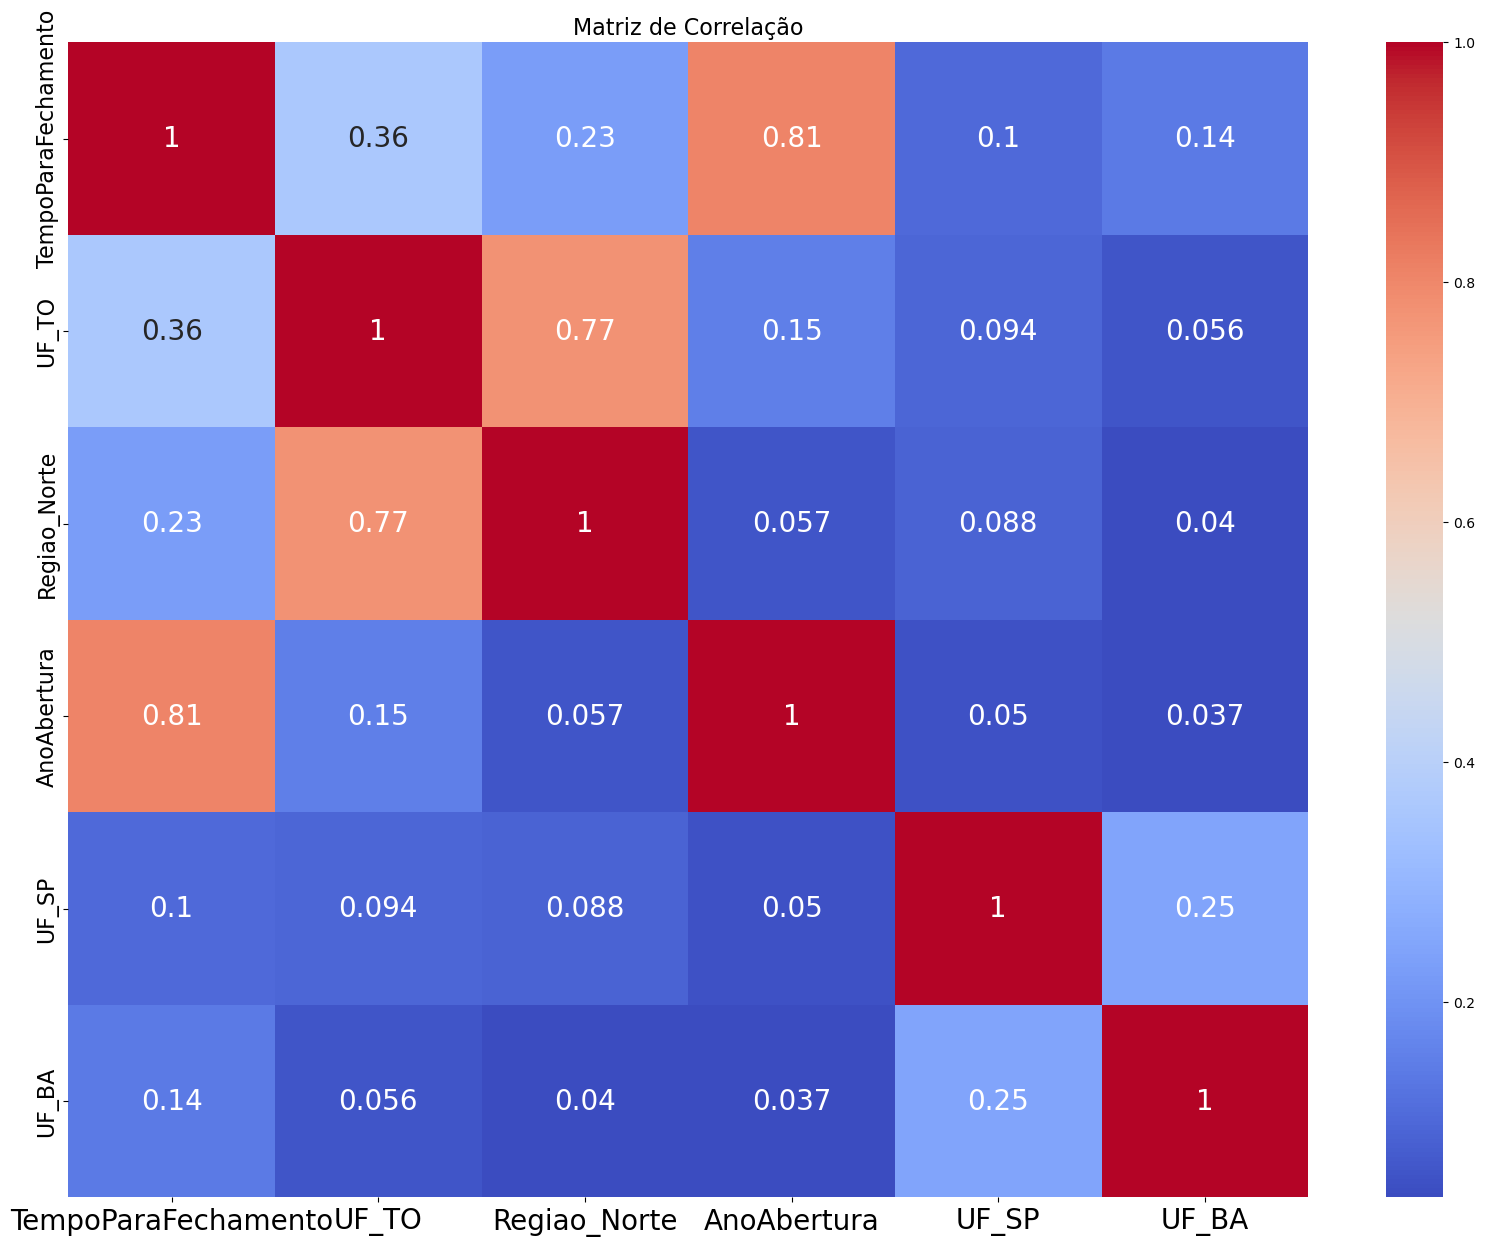

In [ ]:
corr_matrix = matriz_correlacao[['TempoParaFechamento', 'UF_TO', 'Regiao_Norte', 'AnoAbertura', 
                   'UF_SP', 'UF_BA']].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize": 20})

plt.title('Matriz de Correlação', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)

plt.show()


Falar sore os resultados da correlação

## 4. Construa um modelo de regressão linear em que queremos estimar o tempo de uma reclamação ativa.

Separação dos conjuntos de treino e teste

In [ ]:
df_regressao_norm = df_regressao_norm.drop_duplicates()

In [ ]:
X = df_regressao_norm.drop(columns='TempoParaFechamento')
y = df_regressao_norm['TempoParaFechamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Função para instanciar e printar as métricas dos modelos

In [ ]:
def modeling(alg, alg_name, params={}):
    '''
    Parameters:
    alg (class): O algoritmo de machine learning.
    alg_name (str): O nome do algoritmo.
    params (dict): Os parametros do algoritmo 

    Returns:
    class: O modelo treinado.
    '''
    model = alg(**params) 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    def print_scores(alg_name, y_true, y_pred):
        print(alg_name)
        mse_score = mean_squared_error(y_true, y_pred)
        print("MSE: ",mse_score)
        rmse_score = mean_squared_error(y_true, y_pred, squared=False)
        print("RMSE: ",rmse_score)
        mae_score = mean_absolute_error(y_true, y_pred)
        print("MAE: ",mae_score)
        r2score = r2_score(y_true, y_pred)
        print("R-squared: ",r2score)

    print_scores(alg, y_test, y_pred)
    return model

# Testando modelo de regressão linear
log_model = modeling(LinearRegression, 'Linear Regression')

<class 'sklearn.linear_model._base.LinearRegression'>
MSE:  0.004819262898281005
RMSE:  0.06942091110235449
MAE:  0.04907295253195925
R-squared:  0.43333978256512085


In [ ]:
import statsmodels.api as sm

#add constant to predictor variables
#X_train = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y_train, X_train).fit()

#view model summary
print(model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     TempoParaFechamento   R-squared (uncentered):                   0.502
Model:                             OLS   Adj. R-squared (uncentered):              0.502
Method:                  Least Squares   F-statistic:                          1.118e+04
Date:                 Tue, 16 May 2023   Prob (F-statistic):                        0.00
Time:                         15:09:53   Log-Likelihood:                      5.0377e+05
No. Observations:               454245   AIC:                                 -1.007e+06
Df Residuals:                   454204   BIC:                                 -1.007e+06
Df Model:                           41                                                  
Covariance Type:             nonrobust                                                  
                                               coef    std err          t      P>|t|      [0.025      0.975]
-

In [ ]:
ds = modeling(DecisionTreeRegressor, 'Decision Tree Regressor')

<class 'sklearn.tree._classes.DecisionTreeRegressor'>
MSE:  0.002649632008447242
RMSE:  0.051474576330915456
MAE:  0.031106724345885548
R-squared:  0.688450063480728


In [ ]:
rf = modeling(RandomForestRegressor, 'Random Forest Regressor')

<class 'sklearn.ensemble._forest.RandomForestRegressor'>
MSE:  0.0025894751004876455
RMSE:  0.05088688534865978
MAE:  0.030957297346819967
R-squared:  0.6955234535953769


In [ ]:
from xgboost import XGBRegressor


xgb = modeling(XGBRegressor, 'XGB Regressor')

<class 'xgboost.sklearn.XGBRegressor'>
MSE:  0.0024440141029259182
RMSE:  0.04943697101285553
MAE:  0.030709020861959983
R-squared:  0.7126270983324224


Salvando e exportando o modelo para ser usado em produção

In [ ]:
with open('modelo_rf', 'wb') as file:
    pickle.dump(rf, file)